In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

In [2]:
import pickle
import pandas as pd
import numpy as np

## Profit plots

In [3]:
game_state_file = './pkl/game_state_batches_H1_R1_deep_R1_1_deep_e55f94_1_deep_R2_1_ppo_P1_1_ppo_P2_1_1000.pkl'

In [4]:
with open(game_state_file, 'rb') as f:
    game_state_batches = pickle.load(f)

In [5]:
gsb = game_state_batches[0]

In [6]:
START_STACK = 400
def get_player_profits(player):
    profits = []
    for gsbs in game_state_batches:
        gsb = gsbs[player]
        mx_len = max(map(len, gsbs.values()))+1
        stacks_sizes = [START_STACK, gsb[0][0]]
        profits_batch = []
        for hand in gsb:
            pre_stack, post_stack, stack_delta, _ = hand
            stacks_sizes.append(pre_stack)
            stacks_sizes.append(post_stack)
        for i in range(1, len(stacks_sizes)):
            profits_batch.append(stacks_sizes[i] - stacks_sizes[i-1])
        # actual_profits_batch = profits_batch
        actual_profits_batch = []
        for i in range(0, len(profits_batch), 2):
            if i+1 >= len(profits_batch):
                actual_profits_batch.append(profits_batch[i])
                break
            actual_profits_batch.append(profits_batch[i] + profits_batch[i+1])
        actual_profits_batch = actual_profits_batch + [0]*(mx_len - len(actual_profits_batch))
        profits += actual_profits_batch
    return profits

In [7]:
profits_dict = {}
for player in gsb.keys():
    profits_dict[player] = get_player_profits(player)

In [8]:
df = pd.DataFrame(profits_dict)

In [9]:
df.columns 

Index(['PlayerDeepAgent_R1_PlayerDeepAgent_14',
       'PlayerRandom_R_PlayerRandom_7',
       'PlayerDeepAgent_R2_PlayerDeepAgent_28',
       'PlayerHeuristic_H_PlayerHeuristic_0',
       'PlayerDeepAgent_e55f94_PlayerDeepAgent_21',
       'PlayerPPO_P1_PlayerPPO_35', 'PlayerPPO_P2_PlayerPPO_42'],
      dtype='object')

In [10]:
df = df.rename(columns={
    'PlayerDeepAgent_e55f94_PlayerDeepAgent_21':"Imitation",
    'PlayerDeepAgent_R1_PlayerDeepAgent_14':"REINFORCE-1",
    'PlayerDeepAgent_R2_PlayerDeepAgent_28':"REINFORCE-2",
    'PlayerPPO_P1_PlayerPPO_35':"PPO-1",
    'PlayerHeuristic_H_PlayerHeuristic_0':"Heuristic",
    'PlayerRandom_R_PlayerRandom_7':"Random",
    'PlayerPPO_P2_PlayerPPO_42': "PPO2"
})

<Axes: title={'center': 'Chips v.s. hand-action for multiple agents.'}, xlabel='hand-action', ylabel='chips'>

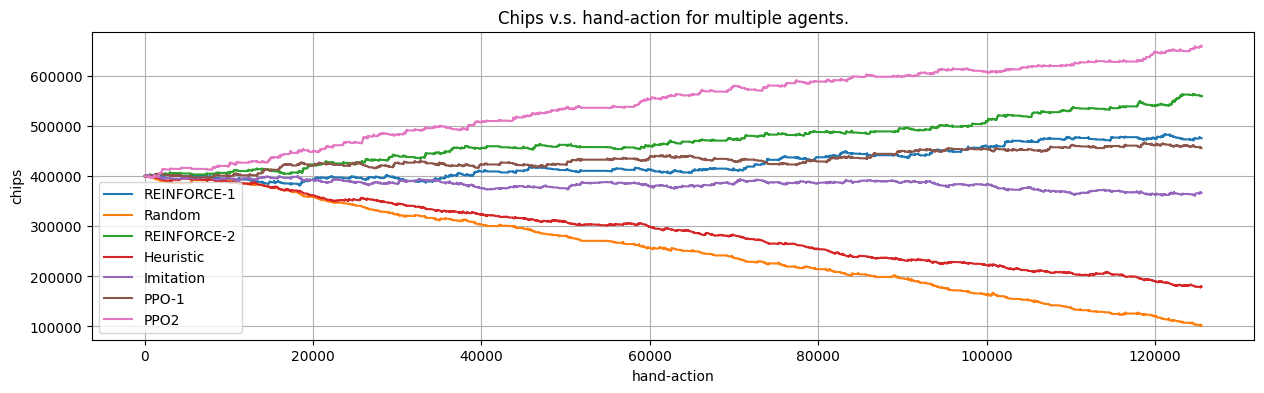

In [13]:
(df.cumsum()+START_STACK*len(game_state_batches)).plot(grid=True, figsize=(15, 4), xlabel="hand-action", ylabel="chips", title="Chips v.s. hand-action for multiple agents.")

<Axes: title={'center': 'Chips v.s. hand-action for multiple agents.'}, xlabel='hand-action', ylabel='chips'>

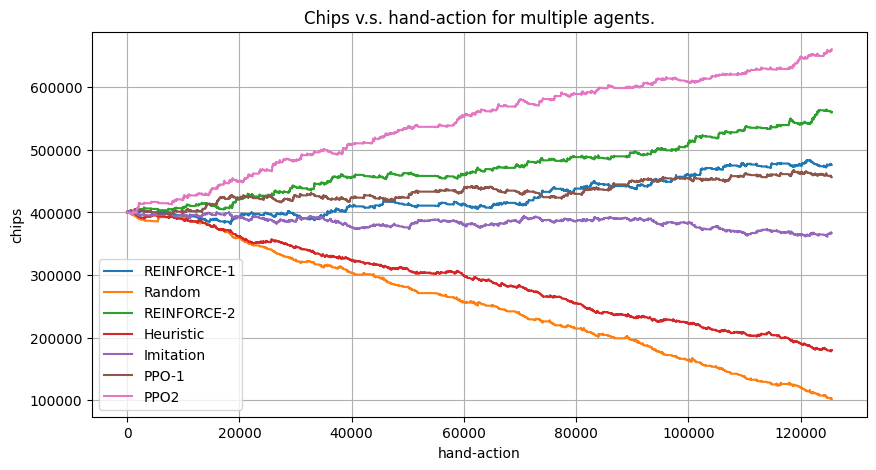

In [17]:
(df.cumsum()+START_STACK*len(game_state_batches)).plot(grid=True, figsize=(10, 5), xlabel="hand-action", ylabel="chips", title="Chips v.s. hand-action for multiple agents.")

## Puzzles

In [18]:
from poker.agents.game_state import GameState, Player
from poker.agents.game_state import *
from poker.core.card import *
from poker.core.card import Rank
from poker.agents.deep_learning_agent import PokerPlayerNetV1
from poker.agents.ppo_agent import PPOPokerNet
from poker.player_deep_agent import PlayerDeepAgent
import torch

In [19]:
def _aa_preflop_puzzle():
    p1 = Player(1, (Card(Rank.ACE, Suit.SPADE), Card(Rank.ACE, Suit.CLUB)), 100)
    p2 = Player(0, None, 80)
    p3 = Player(2, None, 90)
    game_state = GameState(
        stage = Stage.PREFLOP,
        community_cards = [],
        pot_size = 3,
        min_bet_to_continue = 0,
        my_player = p1,
        other_players = [p2, p3],
        my_player_action = (Action.RAISE, 10),
        min_allowed_bet=2,
    )
    return game_state

In [20]:
def _27_off_preflop_puzzle():
    p1 = Player(1, (Card(Rank.TWO, Suit.SPADE), Card(Rank.SEVEN, Suit.CLUB)), 100)
    p2 = Player(0, None, 80)
    p3 = Player(2, None, 90)
    game_state = GameState(
        stage = Stage.PREFLOP,
        community_cards = [],
        pot_size = 3,
        min_bet_to_continue = 0,
        my_player = p1,
        other_players = [p2, p3],
        my_player_action = (Action.RAISE, 10),
        min_allowed_bet=2,
    )
    return game_state

In [21]:
def _ak_preflop_puzzle():
    p1 = Player(1, (Card(Rank.ACE, Suit.SPADE), Card(Rank.KING, Suit.CLUB)), 100)
    p2 = Player(0, None, 80)
    p3 = Player(2, None, 90)
    game_state = GameState(
        stage = Stage.PREFLOP,
        community_cards = [],
        pot_size = 3,
        min_bet_to_continue = 0,
        my_player = p1,
        other_players = [p2, p3],
        my_player_action = (Action.RAISE, 10),
        min_allowed_bet=2,
    )
    return game_state

In [22]:
def _aaaa_flop_puzzle():
    p1 = Player(1, (Card(Rank.ACE, Suit.SPADE), Card(Rank.ACE, Suit.CLUB)), 100)
    p2 = Player(0, None, 80)
    p3 = Player(2, None, 90)
    
    p1.add_preflop_action(Action.RAISE, 10)
    p2.add_preflop_action(Action.CHECK_CALL, 0)
    p3.add_preflop_action(Action.CHECK_CALL, 0)
    p3.add_flop_action(Action.CHECK_CALL, 0)
    p2.add_flop_action(Action.CHECK_CALL, 0)
    game_state = GameState(
        stage = Stage.FLOP,
        community_cards = [Card(Rank.ACE, Suit.DIAMOND), Card(Rank.ACE, Suit.HEART), Card(Rank.TWO, Suit.HEART)],
        pot_size = 27,
        min_bet_to_continue = 0,
        my_player = p1,
        other_players = [p2, p3],
        my_player_action = (Action.RAISE, 10),
        min_allowed_bet=2,
    )
    return game_state

In [23]:
def _flush_miss_turn_puzzle():
    p1 = Player(1, (Card(Rank.QUEEN, Suit.SPADE), Card(Rank.KING, Suit.SPADE)), 100)
    p2 = Player(0, None, 80)
    p3 = Player(2, None, 90)
    
    p1.add_preflop_action(Action.RAISE, 10)
    p2.add_preflop_action(Action.CHECK_CALL, 0)
    p3.add_preflop_action(Action.CHECK_CALL, 0)
    p3.add_flop_action(Action.CHECK_CALL, 0)
    p2.add_flop_action(Action.CHECK_CALL, 0)
    p1.add_flop_action(Action.CHECK_CALL, 0)
    p3.add_turn_action(Action.RAISE, 30)
    p2.add_turn_action(Action.CHECK_CALL, 0)
    
    game_state = GameState(
        stage = Stage.TURN,
        community_cards = [Card(Rank.ACE, Suit.DIAMOND), Card(Rank.NINE, Suit.SPADE), Card(Rank.TWO, Suit.SPADE), Card(Rank.TWO, Suit.HEART)],
        pot_size = 87,
        min_bet_to_continue = 30,
        my_player = p1,
        other_players = [p2, p3],
        my_player_action = None,
        min_allowed_bet=2,
    )
    return game_state

In [24]:
def _straight_hit_flop_puzzle():
    p1 = Player(1, (Card(Rank.ACE, Suit.SPADE), Card(Rank.TWO, Suit.CLUB)), 100)
    p2 = Player(0, None, 80)
    p3 = Player(2, None, 90)
    
    p1.add_preflop_action(Action.RAISE, 10)
    p2.add_preflop_action(Action.CHECK_CALL, 0)
    p3.add_preflop_action(Action.CHECK_CALL, 0)
    p3.add_flop_action(Action.CHECK_CALL, 0)
    p2.add_flop_action(Action.CHECK_CALL, 0)
    game_state = GameState(
        stage = Stage.FLOP,
        community_cards = [Card(Rank.THREE, Suit.DIAMOND), Card(Rank.FOUR, Suit.HEART), Card(Rank.FIVE, Suit.HEART)],
        pot_size = 27,
        min_bet_to_continue = 0,
        my_player = p1,
        other_players = [p2, p3],
        my_player_action = None,
        min_allowed_bet=2,
    )
    return game_state

In [25]:
def get_puzzles():
    return {
        "AA PREFLOP":_aa_preflop_puzzle,
        "27 PREFLOP": _27_off_preflop_puzzle,
        "AK PREFLOP": _ak_preflop_puzzle,
        "AAAA FLOP": _aaaa_flop_puzzle,
        "FLUSH MISS TURN" : _flush_miss_turn_puzzle,
        "STRAIGHT HIT FLOP": _straight_hit_flop_puzzle,
    }

In [26]:
@torch.no_grad()
def eval_agent_puzzles(agent):
    puzzles = get_puzzles()
    res_dict = []
    for pname, puzzle in puzzles.items():
        print(pname)
        action_distr, raise_distr = agent.eval_game_state(puzzle())
        print(action_distr, raise_distr)
        print()
        action = torch.argmax(action_distr)
        raise_size = torch.clamp(raise_distr._loc, raise_distr.low, raise_distr.high)
        if action == 2: action_str = "RAISE"
        if action == 1: action_str = "CHECK/CALL"
        if action == 0: action_str = "FOLD"
        if action == 2:
            action_str +=f" - {raise_size:.2f}"
        res_dict.append((pname, action_str))
    return pd.DataFrame(res_dict, columns=("puzzle", "action")).set_index("puzzle")

## Puzzles I agent

In [27]:
my_agent = PokerPlayerNetV1(use_batchnorm=False, use_mse_loss_for_raise=True)
my_agent.eval()
my_agent.load_state_dict("./poker/e55f94.12150310.st")
# my_agent = PlayerDeepAgent("agent", my_agent)

In [28]:
total_params = sum(p.numel() for p in my_agent.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 8745


In [29]:
agent_I_puzzles = eval_agent_puzzles(my_agent)

AA PREFLOP
tensor([0.0249, 0.0264, 0.9488]) TruncatedNormal(u=1.500005, sd=0.078890, low=0.666667, high=33.333332)

27 PREFLOP
tensor([0.8366, 0.0186, 0.1448]) TruncatedNormal(u=1.518047, sd=0.078890, low=0.666667, high=33.333332)

AK PREFLOP
tensor([0.2972, 0.0416, 0.6612]) TruncatedNormal(u=1.509397, sd=0.078890, low=0.666667, high=33.333332)

AAAA FLOP
tensor([0.0044, 0.3359, 0.6598]) TruncatedNormal(u=0.747195, sd=0.078890, low=0.074074, high=3.703704)

FLUSH MISS TURN
tensor([0.3434, 0.4417, 0.2149]) TruncatedNormal(u=0.752405, sd=0.078890, low=0.367816, high=1.149425)

STRAIGHT HIT FLOP
tensor([0.0044, 0.3359, 0.6598]) TruncatedNormal(u=0.747195, sd=0.078890, low=0.074074, high=3.703704)



/opt/homebrew/anaconda3/envs/py-pip/lib/python3.11/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'poker.agents.deep_learning_agent.TruncatedNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


## Puzzles R1 agent

In [30]:
my_agent = PokerPlayerNetV1(use_batchnorm=False, use_mse_loss_for_raise=True)
my_agent.eval()
my_agent.load_state_dict("./R1.st")
# my_agent = PlayerDeepAgent("agent", my_agent)

In [31]:
agent_R1_puzzles = eval_agent_puzzles(my_agent)

AA PREFLOP
tensor([0.0022, 0.0109, 0.9870]) TruncatedNormal(u=0.861861, sd=0.078535, low=0.666667, high=33.333332)

27 PREFLOP
tensor([0.0855, 0.0325, 0.8820]) TruncatedNormal(u=1.032854, sd=0.078548, low=0.666667, high=33.333332)

AK PREFLOP
tensor([0.0744, 0.0315, 0.8942]) TruncatedNormal(u=1.028224, sd=0.078545, low=0.666667, high=33.333332)

AAAA FLOP
tensor([0.0049, 0.3989, 0.5962]) TruncatedNormal(u=0.491776, sd=0.079418, low=0.074074, high=3.703704)

FLUSH MISS TURN
tensor([0.1783, 0.5006, 0.3211]) TruncatedNormal(u=0.342101, sd=0.079085, low=0.367816, high=1.149425)

STRAIGHT HIT FLOP
tensor([0.0049, 0.3989, 0.5962]) TruncatedNormal(u=0.491776, sd=0.079418, low=0.074074, high=3.703704)



/opt/homebrew/anaconda3/envs/py-pip/lib/python3.11/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'poker.agents.deep_learning_agent.TruncatedNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


## Puzzles R2 agent

In [32]:
my_agent = PokerPlayerNetV1(use_batchnorm=False, use_mse_loss_for_raise=True)
my_agent.eval()
my_agent.load_state_dict("./R2.st")
# my_agent = PlayerDeepAgent("agent", my_agent)

In [33]:
agent_R2_puzzles = eval_agent_puzzles(my_agent)

AA PREFLOP
tensor([1.2050e-04, 9.4963e-03, 9.9038e-01]) TruncatedNormal(u=0.682764, sd=0.073341, low=0.666667, high=33.333332)

27 PREFLOP
tensor([0.0204, 0.0377, 0.9419]) TruncatedNormal(u=0.717085, sd=0.075326, low=0.666667, high=33.333332)

AK PREFLOP
tensor([0.0146, 0.0340, 0.9514]) TruncatedNormal(u=0.683248, sd=0.075253, low=0.666667, high=33.333332)

AAAA FLOP
tensor([0.0040, 0.5009, 0.4952]) TruncatedNormal(u=0.320314, sd=0.077448, low=0.074074, high=3.703704)

FLUSH MISS TURN
tensor([0.0599, 0.5783, 0.3618]) TruncatedNormal(u=0.084317, sd=0.077541, low=0.367816, high=1.149425)

STRAIGHT HIT FLOP
tensor([0.0040, 0.5009, 0.4952]) TruncatedNormal(u=0.320314, sd=0.077448, low=0.074074, high=3.703704)



/opt/homebrew/anaconda3/envs/py-pip/lib/python3.11/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'poker.agents.deep_learning_agent.TruncatedNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


## Puzzles P1 agent

In [34]:
my_agent = PPOPokerNet(use_batchnorm=False)
my_agent.eval()
my_agent.load_state_dict("./P1.st")
# my_agent = PlayerDeepAgent("agent", my_agent)

In [35]:
agent_P1_puzzles = eval_agent_puzzles(my_agent)

AA PREFLOP
tensor([2.7750e-20, 7.7709e-01, 2.2291e-01]) TruncatedNormal(u=-0.077830, sd=0.002470, low=0.666667, high=33.333332)

27 PREFLOP
tensor([4.9557e-12, 5.8677e-01, 4.1323e-01]) TruncatedNormal(u=0.024584, sd=0.019640, low=0.666667, high=33.333332)

AK PREFLOP
tensor([1.4066e-12, 5.9998e-01, 4.0002e-01]) TruncatedNormal(u=0.006798, sd=0.016848, low=0.666667, high=33.333332)

AAAA FLOP
tensor([9.4178e-10, 5.0921e-01, 4.9079e-01]) TruncatedNormal(u=0.316654, sd=0.080788, low=0.074074, high=3.703704)

FLUSH MISS TURN
tensor([3.2449e-18, 4.1440e-01, 5.8560e-01]) TruncatedNormal(u=-0.116939, sd=0.002713, low=0.367816, high=1.149425)

STRAIGHT HIT FLOP
tensor([9.4178e-10, 5.0921e-01, 4.9079e-01]) TruncatedNormal(u=0.316654, sd=0.080788, low=0.074074, high=3.703704)



/opt/homebrew/anaconda3/envs/py-pip/lib/python3.11/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'poker.agents.deep_learning_agent.TruncatedNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


## Puzzles P2 agent

In [38]:
my_agent = PPOPokerNet(use_batchnorm=False)
my_agent.eval()
my_agent.load_state_dict("./P2.st")
# my_agent = PlayerDeepAgent("agent", my_agent)

In [39]:
agent_P2_puzzles = eval_agent_puzzles(my_agent)

AA PREFLOP
tensor([1.1321e-12, 1.5025e-01, 8.4975e-01]) TruncatedNormal(u=0.165450, sd=0.183562, low=0.666667, high=33.333332)

27 PREFLOP
tensor([1.6210e-07, 2.8413e-01, 7.1587e-01]) TruncatedNormal(u=0.007830, sd=0.283624, low=0.666667, high=33.333332)

AK PREFLOP
tensor([8.1485e-08, 2.7874e-01, 7.2126e-01]) TruncatedNormal(u=0.008652, sd=0.271838, low=0.666667, high=33.333332)

AAAA FLOP
tensor([1.3616e-09, 1.0245e-01, 8.9755e-01]) TruncatedNormal(u=-0.005873, sd=0.220348, low=0.074074, high=3.703704)

FLUSH MISS TURN
tensor([6.9249e-13, 4.1675e-02, 9.5833e-01]) TruncatedNormal(u=-0.229454, sd=0.082464, low=0.367816, high=1.149425)

STRAIGHT HIT FLOP
tensor([1.3616e-09, 1.0245e-01, 8.9755e-01]) TruncatedNormal(u=-0.005873, sd=0.220348, low=0.074074, high=3.703704)



/opt/homebrew/anaconda3/envs/py-pip/lib/python3.11/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'poker.agents.deep_learning_agent.TruncatedNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [40]:
df = pd.DataFrame([agent_I_puzzles["action"].rename("Imitation"), agent_R1_puzzles["action"].rename("R1"), agent_R2_puzzles["action"].rename("R2"), agent_P1_puzzles["action"].rename("P1"), agent_P2_puzzles["action"].rename("P2")]).T
df

,Imitation,R1,R2,P1,P2
puzzle,,,,,
AA PREFLOP,RAISE - 1.50,RAISE - 0.86,RAISE - 0.68,CHECK/CALL,RAISE - 0.67
27 PREFLOP,FOLD,RAISE - 1.03,RAISE - 0.72,CHECK/CALL,RAISE - 0.67
AK PREFLOP,RAISE - 1.51,RAISE - 1.03,RAISE - 0.68,CHECK/CALL,RAISE - 0.67
AAAA FLOP,RAISE - 0.75,RAISE - 0.49,CHECK/CALL,CHECK/CALL,RAISE - 0.07
FLUSH MISS TURN,CHECK/CALL,CHECK/CALL,CHECK/CALL,RAISE - 0.37,RAISE - 0.37
STRAIGHT HIT FLOP,RAISE - 0.75,RAISE - 0.49,CHECK/CALL,CHECK/CALL,RAISE - 0.07
